In [5]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeArmonkV2, FakeLondonV2, FakeJakartaV2, FakeMelbourneV2
from qiskit.circuit.library import QuantumVolume
from qiskit_algorithms.utils import algorithm_globals
from qiskit import QiskitError
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

In [6]:
# This will make it easier for the estimator to evaluate a Hamiltonian
# INPUT: Dictionary containing measurement outcomes (dict) and their counts and Number of qubits (int)
# OUTPUT: Statevector (class 'qiskit.quantum_info.states.statevector.Statevector')
#----------------------------------------------------------------------------------
from qiskit.quantum_info import Statevector

def statevector_from_counts(counts, num_qubits):
    """
    Convert measurement counts to a statevector.

    Args:
        counts (dict): Dictionary containing measurement outcomes and their counts.
        num_qubits (int): Number of qubits in the quantum circuit.

    Returns:
        Statevector: The statevector corresponding to the given counts.
    """
    statevector_data = []
    total_counts = sum(counts.values())

    for outcome in range(2**num_qubits):
        outcome_str = format(outcome, f'0{num_qubits}b')
        statevector_data.append((counts.get(outcome_str, 0) / total_counts) ** 0.5)
    return Statevector(statevector_data)

# # Example usage:
# # Measurement counts obtained from the quantum circuit
# counts = {'00': 500, '01': 200, '10': 300}

# # Number of qubits in the quantum circuit
# num_qubits = 2

# # Convert counts to statevector
# statevector = statevector_from_counts(counts, num_qubits)

# print("Statevector:", statevector)


In [7]:
import numpy as np
from qiskit.quantum_info import Statevector, SparsePauliOp

def create_hamiltonian_matrix(sparse_pauli_op):
    # Initialize the total Hamiltonian matrix
    num_qubits = sparse_pauli_op.num_qubits
    total_hamiltonian = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)
    
    # Iterate through each term in the SparsePauliOp
    for pauli_string, coeff in zip(sparse_pauli_op.paulis, sparse_pauli_op.coeffs):
        # Start with the identity matrix
        term_matrix = np.eye(1, dtype=complex)
        
        # Construct the term matrix for the current Pauli string
        for pauli in pauli_string.to_label():
            if pauli == 'I':
                pauli_matrix = np.eye(2)
            elif pauli == 'X':
                pauli_matrix = np.array([[0, 1], [1, 0]], dtype=complex)
            elif pauli == 'Y':
                pauli_matrix = np.array([[0, -1j], [1j, 0]], dtype=complex)
            elif pauli == 'Z':
                pauli_matrix = np.array([[1, 0], [0, -1]], dtype=complex)
            else:
                raise ValueError(f"Unexpected Pauli operator: {pauli}")
            term_matrix = np.kron(term_matrix, pauli_matrix)
        
        # Add the term to the total Hamiltonian
        total_hamiltonian += coeff * term_matrix
    
    return total_hamiltonian

def compute_expectation(statevector: Statevector, hamiltonian: SparsePauliOp) -> complex:
    """
    Compute the expectation value of the given Hamiltonian with respect to the given statevector.
    
    Args:
        statevector (Statevector): The statevector representing the quantum state.
        hamiltonian (SparsePauliOp): The Hamiltonian terms in SparsePauliOp form.
    
    Returns:
        complex: The expectation value of the Hamiltonian.
    """
    # Convert SparsePauliOp to a matrix
    hamiltonian_matrix = create_hamiltonian_matrix(hamiltonian)
    
    # Compute the expectation value
    statevector_array = statevector.data
    expectation_value = np.vdot(statevector_array, hamiltonian_matrix @ statevector_array)
    
    return expectation_value.real

In [8]:
# INPUT: Dictionary (dic)
# OUTPUT: Dictionary with normalized  values (dic)
def normalize(counts):
    counts_norm = {}
    for key , val in counts.items():
        counts_norm[key] =  val/ sum(counts.values()) 
    return counts_norm

### 1) Hammer Error Mitigation Technique

In [9]:
def hamming_distance(x, y):
    """
    Calculate the Hamming distance between two strings.

    Parameters:
        x: First string.
        y: Second string.

    Returns:
        int: Hamming distance between the two strings.
    """
    
    x = np.array(list(x))
    y = np.array(list(y))
    
    return np.sum(x != y)

In [10]:
def hammer(p_in,n):
    
    """
    Update a probability distribution based on Hamming distances.

    Parameters:
        p_in (dict): Input probability distribution where keys are strings and values are probabilities.
        n (int): Length of strings in the input distribution.

    Returns:
        dict: Updated probability distribution.
    """
    
    # Step-1: Create Hamming Spectrum
    """
    1) Iterate through all pairs of strings in the input probability distribution.
    2) Calculate the Hamming distance between each pair of strings.
    3) Accumulate the probabilities of strings that have a Hamming distance within a certain range (n // 2) into an array chs. 
        
    """
    chs = np.zeros(n//2)
    for x in p_in:
        for y in p_in:
            d = hamming_distance(x, y)
            if d < n//2:
                chs[d] += p_in[y]
    
    # Step-2: Compute Per-Distance Weights
    """ 
    1) Iterate through the Hamming distances computed in the previous step.
    2) If the count of strings at a particular Hamming distance is greater than zero, computes and stores(w) the weight as the reciprocal of that count.
    
    """
    w = np.zeros(n//2)
    for d in range(n//2):
        if chs[d] > 0:
            w[d] = 1 / chs[d]
    
    # Step-3: Update the Probability Distribution
    """
    1) Updates each string's probability by considering its similarity to other strings within a certain Hamming distance.
    2) It iterates through each string, adjusting its probability based on the probabilities of similar strings weighted by their Hamming distance. 
    3) Finally, it stores the updated probabilities in a dictionary
    
    """
    p_out = {}
    for x in p_in:
        score = p_in[x]
        for y in p_in:
            d = hamming_distance(x, y)
            if d < n//2 and p_in[x] > p_in[y]:
                score += w[d] * p_in[y]
        p_out[x] = score * p_in[x]
    
    # Normalize the probability distribution
    total = sum(p_out.values())
    p_out = {key: value / total for key, value in p_out.items()}
    
    return p_out

### 2) M3 Error Mitigation Technique

In [15]:
import mthree

In [19]:
def M3(backend, counts_noisy, Q):
    mit = mthree.M3Mitigation(backend)
    mit.cals_from_system(range(Q))
    quasis = mit.apply_correction(counts_noisy, range(Q))
    prob_list_fake_M3 = quasis.nearest_probability_distribution()
    
    counts_fake_M3 = {key: value * 2048 for key, value in prob_list_fake_M3.items()}
    
    return prob_list_fake_M3, counts_fake_M3

### 3) ZNE Error Mitigation Technique

In [21]:
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator
from qiskit.primitives import BackendEstimator

In [23]:
def zne_hamiltonian(num_qubits):
    pauli_list = []
    for i in range(num_qubits):
        pauli_string = ['I'] * num_qubits
        pauli_string[i] = 'Z'
        pauli_list.append(("".join(pauli_string), 1.0))
    
    hamiltonian = SparsePauliOp.from_list(pauli_list)
    return hamiltonian

# Example usage:
num_qubits = 6
hamiltonian = zne_hamiltonian(num_qubits)
print(hamiltonian)

SparsePauliOp(['ZIIIII', 'IZIIII', 'IIZIII', 'IIIZII', 'IIIIZI', 'IIIIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [24]:
def ZNE_EM(backend, Q):

    ## Build ZNEEstimator
    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)

    ## Build a ZNE strategy
    zne_strategy = ZNEStrategy(
    noise_factors=range(1, 9),
    noise_amplifier=LocalFoldingAmplifier(),
    extrapolator=PolynomialExtrapolator(degree=2),
    )
    
    zne_Hamiltonian = zne_hamiltonian(Q) # Hamiltonian Format has to be modifies accordingly
    qc_zne = qc.decompose(reps=1)
    
    job = estimator.run(qc_zne, zne_Hamiltonian, zne_strategy=zne_strategy)
    result = job.result()  
    
    return result.values[0]

### 4) PEC Error Mitigation Technique

Will Update it soon after reviewing Trivikram's code

### EM Module Example Usage

In [11]:
n = 4
n_l = 1
parameters = [0.35639821, 1.83116028, 0.35237865, 0.05872481, 0.47333053, 0.72818138,
 0.67848991, 0.06465341, 0.49701685, 0.19592492, 0.0345368,  0.9796208,
 0.7048751,  0.36096984, 0.77599956, 0.79115251]

backend_fake = FakeLondonV2()
backend_ideal = AerSimulator()

circuit = EfficientSU2(n,reps=n_l,entanglement='circular')
circuit.assign_parameters(parameters)

In [12]:
def circuit_run(circuit, backend, hamiltonian): 
   circuit = circuit.assign_parameters(parameters)
   circuit.measure_all()
   tcirc = transpile(circuit, backend)
   job = backend.run(tcirc)
   counts = job.result().get_counts()
   total_counts = sum(counts.values())
   #Making a List of probabilities from counts 
   prob_list = normalize(counts)
   # SV From Counts
   statevector = statevector_from_counts(prob_list, n)
   # Exp from SV and Hamiltonian
   exp_val = compute_expectation(statevector, hamiltonian)
   
   return  prob_list,statevector, exp_val

In [13]:
operator_strings = ['ZZZI', 'ZZIZ', 'ZIZZ', 'IZZZ', 'XXXI', 'XXIX']

for s in operator_strings: #this for loop is for Y HZH
    
    qc = circuit
    
    pauli_terms = [
        (s, 1.0)
    ]
    
    hamiltonian = SparsePauliOp.from_list(pauli_terms)
    
    for qubit in range(n):
        if(s[qubit] == "X"):
            qc.h(qubit)
        
        elif s[qubit] == "Y":
           qc.sdg(qubit)  # Apply S^\dagger gate (conjugate of S gate)
           qc.h(qubit)
          
    
    prob_list_ideal, statevector_ideal, exp_value_ideal = circuit_run(qc, backend_ideal, hamiltonian)
    prob_list_fake, statevector_fake, exp_value_fake = circuit_run(qc, backend_fake, hamiltonian)
            
    '''
    prob_list_ideal = circuit_run(circuit, backend_ideal, hamiltonian).prob_list
    statevector_ideal = circuit_run(circuit, backend_ideal, hamiltonian).statevector     
    exp_value_ideal = circuit_run(circuit, backend_ideal, hamiltonian).exp_value  
                
    prob_list_fake = circuit_run(circuit,backend_fake, hamiltonian).prob_list
    statevector_fake = circuit_run(circuit,backend_fake, hamiltonian).statevector
    exp_value_fake = circuit_run(circuit,backend_fake, hamiltonian).exp_val
    
    '''
    
    p_hammer = hammer(prob_list_fake,n)
    statevector_fake_H = statevector_from_counts(p_hammer,n)
    
    exp_value_fake_H = compute_expectation(statevector_fake_H,hamiltonian)
    print(exp_value_ideal, "|", exp_value_fake, "|", exp_value_fake_H)

-0.171875 | -0.08398437500000006 | -0.24432826108776054
0.3515625 | 0.23828125 | 0.6497411804086122
0.3847656249999999 | 0.26171874999999994 | 0.6866078441545282
0.69921875 | 0.43359375 | 0.8213148914612348
0.942913909129578 | 0.9772975146514824 | 0.9136198506989367
0.5522751141714051 | 0.7595169129561987 | 0.34677407124905846


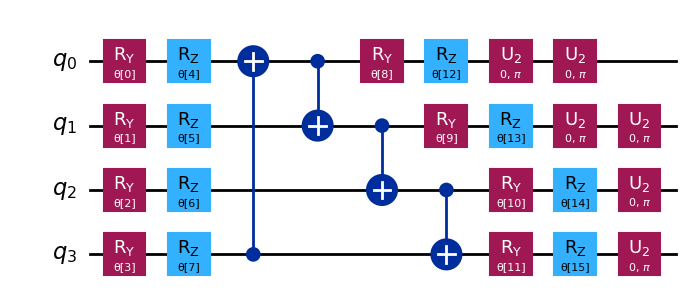

In [14]:
circuit.decompose().draw("mpl")